#### Task 1
 Set up and Data preparation
 

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


#Load a part of the data to make things faster
df = pd.read_csv("../data/transactions_train.csv").head(500000)

#Preprocessing the IDS into continuous integer codes that the embedding layer can use.

#creating user and item encoders
user_encoder = LabelEncoder()
article_encoder = LabelEncoder()

# Fit and transform the IDs to integer codes
df['user_code'] = user_encoder.fit_transform(df['customer_id'])
df['article_code'] = article_encoder.fit_transform(df['article_id'])

# Get the number of unique users and articles
n_users = df['user_code'].nunique()
n_articles = df['article_code'].nunique()

print(f"Number of unique users: {n_users}")
print(f"Number of unique articles: {n_articles}")


#Creating Training Data
# Positive examples (the ones we have)
X = df[['user_code', 'article_code']].values #to create numpy array of the user and the item beside
y = np.ones(len(df)) # All are purchases, so target is 1,an array of 1's as the target

# In a full project, we would add "negative samples" here (target=0) so that we can allow the model know or understand when the user didn't buy 
# For today, we will skip this step to focus on the model architecture.







Number of unique users: 119904
Number of unique articles: 24942


In [12]:
# Create DataFrame for user mapping
user_mapping = pd.DataFrame({
    'user_code': range(len(user_encoder.classes_)),
    'customer_id': user_encoder.classes_
})

# Create DataFrame for article mapping
article_mapping = pd.DataFrame({
    'article_code': range(len(article_encoder.classes_)),
    'article_id': article_encoder.classes_
})

print(user_mapping.head())
print(article_mapping.head())


   user_code                                        customer_id
0          0  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
1          1  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
2          2  00007d2de826758b65a93dd24ce629ed66842531df6699...
3          3  0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...
4          4  00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d...
   article_code  article_id
0             0   108775015
1             1   108775044
2             2   108775051
3             3   110065001
4             4   110065002


#### Task 2
Building the Model Architecture

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define embedding size
embedding_dim = 32

# --- User Input Pathway ---
user_input = layers.Input(shape=(1,), name='user_input')#one input only
user_embedding = layers.Embedding(n_users, embedding_dim, name='user_embedding')(user_input)
user_vec = layers.Flatten(name='flatten_user')(user_embedding)

# --- Article Input Pathway ---
article_input = layers.Input(shape=(1,), name='article_input') #shape 1 means it would accept one input only
article_embedding = layers.Embedding(n_articles, embedding_dim, name='article_embedding')(article_input)
article_vec = layers.Flatten(name='flatten_article')(article_embedding)

# --- Combine & Create Model ---
concatenated = layers.Concatenate()([user_vec, article_vec])
dense_1 = layers.Dense(128, activation='relu')(concatenated)
dense_2 = layers.Dense(64, activation='relu')(dense_1)
output = layers.Dense(1, activation='sigmoid')(dense_2) # Sigmoid for 0-1 probability

model = keras.Model(inputs=[user_input, article_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ article_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │  3,836,928 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ article_embedding   │ (None, 1, 32)     │    798,144 │ article_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_user        │ (None, 32)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_article     │ (None, 32)        │          0 │ article_embeddin… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ flatten_user[0][… │
│ (Concatenate)       │                   │            │ flatten_article[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      8,320 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,651,713 (17.74 MB)

 Trainable params: 4,651,713 (17.74 MB)

 Non-trainable params: 0 (0.00 B)

Generating Negative samples

In [7]:
# Ensure you've run the code from yesterday to create df, user_encoder, etc.

# Create a set of all unique article codes for fast lookup
all_article_codes = set(df['article_code'].unique())

# Create a dictionary of items purchased by each user
user_purchases = df.groupby('user_code')['article_code'].apply(set)

neg_samples = []
for user_code in df['user_code'].unique():
    # Get the set of articles this user has purchased
    purchased_articles = user_purchases[user_code]

    # Find articles the user has NOT purchased
    unpurchased_articles = all_article_codes - purchased_articles

    # Randomly sample N negative items, where N is the number of positive items
    num_positives = len(purchased_articles)
    neg_items = np.random.choice(list(unpurchased_articles), size=num_positives, replace=False)

    for item_code in neg_items:
        neg_samples.append([user_code, item_code, 0]) # user, item, target=0

# Create the negative samples DataFrame
neg_df = pd.DataFrame(neg_samples, columns=['user_code', 'article_code', 'target'])

# Get positive samples from the original dataframe
pos_df = df[['user_code', 'article_code']]
pos_df['target'] = 1

# Concatenate positive and negative DataFrames
final_df = pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

print(f"Total training samples: {len(final_df)}")
display(final_df.head())



Total training samples: 947349


C:\Users\hp\AppData\Local\Temp\ipykernel_2472\3285399110.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df['target'] = 1


,user_code,article_code,target
0,84257,2764,1
1,13309,11394,1
2,108507,15730,0
3,54185,2420,1
4,20405,9579,0


Training the model

In [11]:
import joblib

joblib.dump(user_purchases, '../artifacts/user_purchases.pkl')


['../artifacts/user_purchases.pkl']

In [8]:
X_train = [final_df['user_code'], final_df['article_code']]
y_train = final_df['target']

# (Re-run the cell where you defined and compiled your model architecture)

print("Starting model training on balanced data...")
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=5,       # Keep epochs low for today's exercise
    batch_size=256,
    validation_split=0.1, # Use 10% of the data for validation
    verbose=1
)
print("Training finished.")


Starting model training on balanced data...
Epoch 1/5
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 120s 35ms/step - accuracy: 0.7185 - loss: 0.5425 - val_accuracy: 0.7754 - val_loss: 0.4720
Epoch 2/5
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 127s 38ms/step - accuracy: 0.8007 - loss: 0.4175 - val_accuracy: 0.7853 - val_loss: 0.4618
Epoch 3/5
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 125s 37ms/step - accuracy: 0.8541 - loss: 0.3233 - val_accuracy: 0.7813 - val_loss: 0.4963
Epoch 4/5
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 120s 36ms/step - accuracy: 0.9185 - loss: 0.1963 - val_accuracy: 0.7747 - val_loss: 0.6162
Epoch 5/5
1593/3331 ━━━━━━━━━━━━━━━━━━━━ 1:09 40ms/step - accuracy: 0.9713 - loss: 0.0814

KeyboardInterrupt: 

### Strategy for Generating Recommendations

To get the top 10 recommendations for a specific user (`user_X`):

1.  **Identify Candidate Items**: Get a list of all unique article codes that the user has *not* previously purchased.
2.  **Create User-Item Pairs**: Create a DataFrame with two columns: one repeating `user_X`'s code, and the other containing all the candidate article codes.
3.  **Predict Probabilities**: Use `model.predict()` on these pairs. The model will output a "purchase probability" for each candidate item.
4.  **Rank and Select**: Sort the articles based on their predicted probability in descending order.
5.  **Return Top-K**: The top 10 articles from this sorted list are the final recommendations.


#### Plot Training History



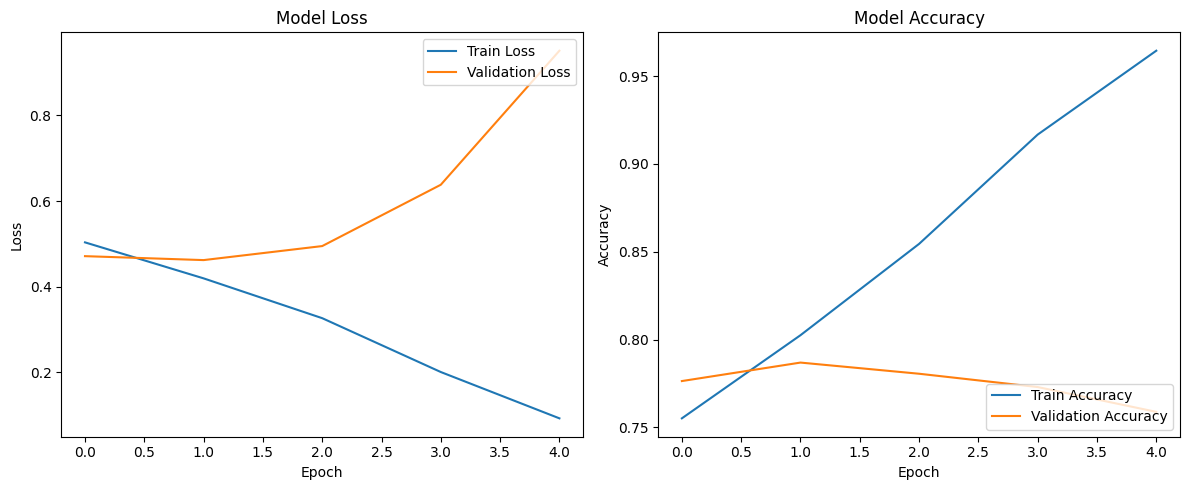

In [ ]:
import matplotlib.pyplot as plt

# plot training & validation loss values
plt.figure(figsize=(12,5)) #creates the width and size of how the whole plot would be
plt.subplot(1,2,1) #the first 1 is the n_row,2 is n_column and last 1 is the position which is left side
plt.plot(history.history['loss'], label='Train Loss') #when we use fit() it returns and history object which is stored in an history variable so to access it,we do history.history[]
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right') #shows what each colour line on the graph shows using the label we did above


#Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout() # To create enough space for each plot and prevent overlapping
plt.show()#normal py file won't show the plot without this



#### Are there signs of overfitting?
There are,from the look of the first plot the curve of the loss train tends to converge i.e reduces as it completes each epoch, but the validation loss tends to increase as each epoch completes therefore leads to overfitting.
Observing the second plot the train accuracy increases as it completes each epoch while the validation accurach reduces therefore leads to overfitting.

#### Extracting and Visualizing Article Embeddings


In [10]:
from sklearn.decomposition import PCA
import seaborn as sns
articles_df = pd.read_csv('../data/articles.csv') 


#Get the embedding layer
article_embedding_layer = model.get_layer('article_embedding')

#Get the weights(the learned embeddings)
article_embeddings = article_embedding_layer.get_weights()[0] #the vector weights

print(f"Shape of article embeddings: {article_embeddings.shape}")



#Reducing the Dimensionality with PCA(principal Component Analysis)


#Using PCA to reduce dimensions from 32 to 2
pca = PCA(n_components=2) #selecting the number of dimensions to reduce to

article_embeddings_2d =pca.fit_transform(article_embeddings)


#Visualizing the 2D embedding

unique_product_types = articles_df['product_type_name'].unique()
articles_df_subset = articles_df.drop_duplicates(subset=['article_id']).copy()

article_encoder = LabelEncoder()
article_encoder.fit(articles_df_subset['article_id'])
articles_df_subset['article_code'] = article_encoder.transform(articles_df_subset['article_id'])

# Create a mapping from article_code to product_type_name
code_to_type = articles_df_subset.set_index('article_code')['product_type_name']

# We'll visualize a random sample to avoid overplotting
sample_indices = np.random.choice(len(article_embeddings_2d), size=5000, replace=False)#Random rows

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=article_embeddings_2d[sample_indices, 0],
    y=article_embeddings_2d[sample_indices, 1],
    hue=[code_to_type.get(i, 'Unknown') for i in sample_indices],# This row is saying for every sample indexcontaining a random row number use it to look up the product name then colour the points based on it's product type.hue is used to colour the data points based on a category or label
    palette="tab20",#Transparency of the plot elements
    alpha=0.7,
    legend=False # Legend would be too crowded
)
plt.title('Article Embeddings Visualized with PCA (colored by Product Type)')
plt.show()







Shape of article embeddings: (24942, 32)


NameError: name 'plt' is not defined

In [ ]:
import joblib
from tensorflow.keras.models import save_model

save_model(model, "../artifacts/collab_model.h5")        # Save the trained CF model
joblib.dump(user_encoder, "../artifacts/user_encoder.pkl")   # Save user ID mapping
joblib.dump(article_encoder, "../artifacts/article_encoder.pkl") # Save article ID mapping
joblib.dump(user_purchases, '../artifacts/user_purchases.pkl')


['../artifacts/user_purchases.pkl']